In [1]:
#Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
%matplotlib inline
sns.set()
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

#Cargando la data
data=pd.read_csv('petroleo.csv')
data.head()

,fecha,ultimo,apertura,maximo,minimo,vol,var
0,2003-01-02,31.85,31.60,32.09,31.40,62480.0,2.08
1,2003-01-03,33.08,31.98,33.25,31.90,68420.0,3.86
2,2003-01-06,32.10,33.08,33.33,31.91,98250.0,-2.96
3,2003-01-07,31.08,32.11,32.40,30.51,124280.0,-3.18
4,2003-01-08,30.56,31.05,31.30,29.75,108040.0,-1.67


In [2]:
#En series de tiempo, se debe tener la fecha como índice
data['fecha'] = pd.to_datetime(data.fecha,format='%Y-%m-%d')
data.index = data['fecha']

#Obtener la data de manera ascendente en el tiempo
data = data.sort_index(ascending=True, axis=0)
data.head()

,fecha,ultimo,apertura,maximo,minimo,vol,var
fecha,,,,,,,
2003-01-02,2003-01-02,31.85,31.60,32.09,31.40,62480.0,2.08
2003-01-03,2003-01-03,33.08,31.98,33.25,31.90,68420.0,3.86
2003-01-06,2003-01-06,32.10,33.08,33.33,31.91,98250.0,-2.96
2003-01-07,2003-01-07,31.08,32.11,32.40,30.51,124280.0,-3.18
2003-01-08,2003-01-08,30.56,31.05,31.30,29.75,108040.0,-1.67


In [34]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(data)),columns=['fecha', 'ultimo'])
for i in range(0,len(data)):
    new_data['fecha'][i] = data['fecha'][i]
    new_data['ultimo'][i] = data['ultimo'][i]

#setting index
new_data.index = new_data.fecha
new_data.drop('fecha', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:3819,:]
valid = dataset[3819:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=30))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 275s - loss: 0.0018


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


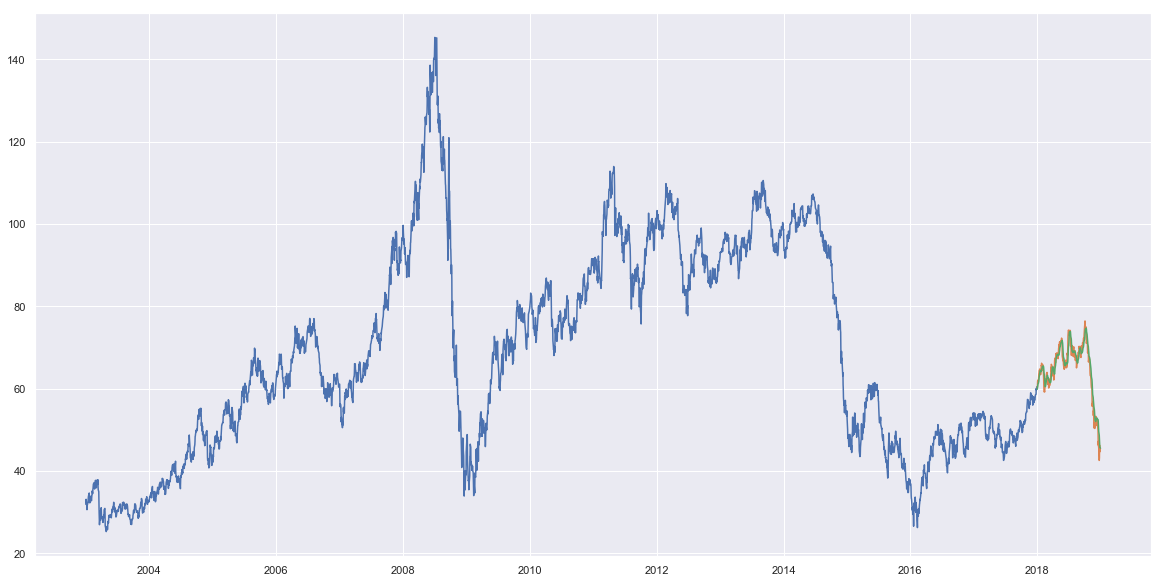

In [35]:
#for plotting
plt.rcParams['figure.figsize'] = [20, 10]
train = new_data[:3819]
valid = new_data[3819:]
valid['Predictions'] = closing_price
plt.plot(train['ultimo'])
plt.plot(valid[['ultimo','Predictions']])

In [ ]:
plt.plot(valid[['ultimo','Predictions']])

In [ ]:
rms=np.sqrt(np.mean(np.power((valid['Predictions']-valid['ultimo']),2)))
rms